In [31]:
import pandas as pd
import numpy as np

REDWINE_PATH = "../datasets/winequality-red.csv"
WHITEWINE_PATH = "../datasets/winequality-white.csv"

# try different number of dimensions to see the effect in accuracy 
DIM_NO = 7

# timer start
import time 
start = time.time()

# read red wine set of observations
data_red = pd.read_csv(REDWINE_PATH,sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

# read white wine set of observations
data_white = pd.read_csv(WHITEWINE_PATH,sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

# merge the two sets in one
data = data_red.merge(data_white, how='outer')
fields = list(data.columns)
print(fields)

(1599, 13)
(4898, 13)
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


In [32]:
# show the counts of all quality levels
print("All 'quality level' counts")
print(data["quality"].value_counts())

All 'quality level' counts
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [33]:
# based on the "quality histograms" above, we will drop the ratings with low counts (we will keep only 5,6,7)
data = data.drop(data[data.quality == 9].index)
data = data.drop(data[data.quality == 8].index)
data = data.drop(data[data.quality == 3].index)
data = data.drop(data[data.quality == 4].index)

# show the counts of selected quality levels
print("Selected 'quality level' counts")
print(data["quality"].value_counts())

Selected 'quality level' counts
6    2836
5    2138
7    1079
Name: quality, dtype: int64


In [34]:
# split the data set in two: 1) color+features (observations)  2) quality (actuals)

# select the outcomes
y = data['quality']

data = data.drop(columns=['quality'])

# select the rows (observations)
fields = list(data.columns)
X = data[fields]
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


We will use a dimensionality reduction through Principal Component Analysis to identify only a subset of the componenta that drive the dynamics of the dataset and have other correkated dimensions with the same direction of impact but less strength. We will retain only the components that altogether amount to at least 65% of the accummulated eigen values


In [35]:
# now let's try to find the most important features by using PCA
# first off drop off the remaining non-chemical features.
data = data.drop(columns=['color'])
fields = list(data.columns)
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


[0.2812138845440715, 0.2253415991254009, 0.14112902232389624, 0.08521911434306068, 0.06594236811149971, 0.05517392086025881, 0.04717623443524541, 0.044540482246072564, 0.03069485623703559, 0.02061524915127792, 0.0029532686221809263]
[28.12 50.65 64.76 73.28 79.87 85.39 90.11 94.56 97.63 99.69 99.99]


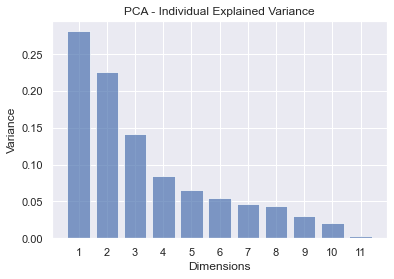

[[ 3.22576744  0.41102896 -2.80018819 ... -0.01978679 -0.10947096
   0.01529315]
 [ 3.22576744  0.41102896 -2.80018819 ... -0.01978679 -0.10947096
   0.01529315]
 [ 3.0803782   1.1081831  -2.10888328 ...  0.45879586 -0.28024376
  -0.03173186]
 ...
 [-0.5899141  -0.75755992  0.0849859  ...  0.1193659  -0.35116319
   0.16074081]
 [-0.10690003 -3.59768863  0.08976857 ...  0.29385227  0.27203213
   0.049235  ]
 [-0.53211027 -2.94597678  0.70908899 ...  0.22134967 -0.11090156
   0.0057377 ]]


In [36]:
#refs: https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
#refs: https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import time
%matplotlib inline

X = data[fields]
X = scale(X)

pca = PCA(n_components=11)
pca.fit(X)

eigvar= pca.explained_variance_ratio_
print(eigvar.tolist())
cum_var_exp=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(cum_var_exp)

dims = ('1','2','3','4','5','6','7','8','9','10','11')
y_pos = np.arange(len(dims))

plt.bar(y_pos, eigvar, align='center', alpha=0.7)
plt.xticks(y_pos, dims)
plt.ylabel('Variance')
plt.xlabel('Dimensions')
plt.title('PCA - Individual Explained Variance')

plt.show()

XPca=pca.fit_transform(X)
print(XPca)

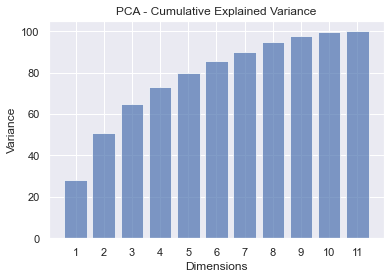

In [37]:
plt.bar(y_pos, cum_var_exp, align='center', alpha=0.7)
plt.xticks(y_pos, dims)
plt.ylabel('Variance')
plt.xlabel('Dimensions')
plt.title('PCA - Cumulative Explained Variance')

plt.show()

We will run now K_Nearest Neighbour algorithm (KNN) to create a "prediction model"
KNN converges faster when features are scaled. If the model is senstive to magnitudes its generally a good idea to scale so one feature doesn’t get more influence than the other(in terms of scale).

In [38]:
XPcaDf = pd.DataFrame(data = XPca,columns = ['Dim1','Dim2','Dim3','Dim4','Dim5','Dim6','Dim7','Dim8','Dim9','Dim10','Dim11'])
print(XPcaDf)

          Dim1      Dim2      Dim3      Dim4      Dim5      Dim6      Dim7  \
0     3.225767  0.411029 -2.800188 -0.852343  0.199122 -0.265351 -0.194558   
1     3.225767  0.411029 -2.800188 -0.852343  0.199122 -0.265351 -0.194558   
2     3.080378  1.108183 -2.108883 -0.931437 -1.276995  1.731359 -0.029815   
3     3.114580  0.863640 -1.804274 -0.919626 -0.733310  0.897621  0.142934   
4     1.652820  2.021409  2.608647 -0.267437  0.594091 -0.826626 -0.477675   
...        ...       ...       ...       ...       ...       ...       ...   
6048  0.054442 -1.986983  0.189462  0.191258 -0.006353 -0.571107  0.417440   
6049 -1.881734  0.529466 -0.400523  0.173811 -0.529238  0.209778 -0.331691   
6050 -0.589914 -0.757560  0.084986 -0.989145 -1.230461 -0.387528  1.348390   
6051 -0.106900 -3.597689  0.089769 -0.063209  0.225839 -0.182203 -0.553685   
6052 -0.532110 -2.945977  0.709089 -0.431966  0.087337 -0.895315 -0.435394   

          Dim8      Dim9     Dim10     Dim11  
0    -0.621275 -

In [39]:
if (DIM_NO == 8):
    # since the first 5 dimensions amount to 80% of data variability, drop the dimensions >=6
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)
elif (DIM_NO == 7):
    # since the first 5 dimensions amount to 80% of data variability, drop the dimensions >=6
    XPcaDf = XPcaDf.drop('Dim8', 1)
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)
elif (DIM_NO == 6):
    # since the first 5 dimensions amount to 80% of data variability, drop the dimensions >=6
    XPcaDf = XPcaDf.drop('Dim7', 1)
    XPcaDf = XPcaDf.drop('Dim8', 1)
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)
elif (DIM_NO == 5):
    # since the first 5 dimensions amount to 80% of data variability, drop the dimensions >=6
    XPcaDf = XPcaDf.drop('Dim6', 1)
    XPcaDf = XPcaDf.drop('Dim7', 1)
    XPcaDf = XPcaDf.drop('Dim8', 1)
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)
elif (DIM_NO == 4):
    XPcaDf = XPcaDf.drop('Dim5', 1)
    XPcaDf = XPcaDf.drop('Dim6', 1)
    XPcaDf = XPcaDf.drop('Dim7', 1)
    XPcaDf = XPcaDf.drop('Dim8', 1)
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)
elif (DIM_NO == 3):
    XPcaDf = XPcaDf.drop('Dim4', 1)
    XPcaDf = XPcaDf.drop('Dim5', 1)
    XPcaDf = XPcaDf.drop('Dim6', 1)
    XPcaDf = XPcaDf.drop('Dim7', 1)
    XPcaDf = XPcaDf.drop('Dim8', 1)
    XPcaDf = XPcaDf.drop('Dim9', 1)
    XPcaDf = XPcaDf.drop('Dim10', 1)
    XPcaDf = XPcaDf.drop('Dim11', 1)


print(XPcaDf)

          Dim1      Dim2      Dim3      Dim4      Dim5      Dim6      Dim7
0     3.225767  0.411029 -2.800188 -0.852343  0.199122 -0.265351 -0.194558
1     3.225767  0.411029 -2.800188 -0.852343  0.199122 -0.265351 -0.194558
2     3.080378  1.108183 -2.108883 -0.931437 -1.276995  1.731359 -0.029815
3     3.114580  0.863640 -1.804274 -0.919626 -0.733310  0.897621  0.142934
4     1.652820  2.021409  2.608647 -0.267437  0.594091 -0.826626 -0.477675
...        ...       ...       ...       ...       ...       ...       ...
6048  0.054442 -1.986983  0.189462  0.191258 -0.006353 -0.571107  0.417440
6049 -1.881734  0.529466 -0.400523  0.173811 -0.529238  0.209778 -0.331691
6050 -0.589914 -0.757560  0.084986 -0.989145 -1.230461 -0.387528  1.348390
6051 -0.106900 -3.597689  0.089769 -0.063209  0.225839 -0.182203 -0.553685
6052 -0.532110 -2.945977  0.709089 -0.431966  0.087337 -0.895315 -0.435394

[6053 rows x 7 columns]


In [40]:
# apply normalization to the eigenspace

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

DO_STANDARDSCALER = True
scaler = None
fields = list(XPcaDf.columns)
if DO_STANDARDSCALER:
    scaler = StandardScaler().fit(XPcaDf)
    X = scaler.transform(XPcaDf)

    X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
    print(X.columns) #scaled columns

    print(scaler.mean_)
    print(scaler.scale_)

else:
    scaler = MinMaxScaler().fit(XPcaDf)
    print(scaler.data_max_)
    print(scaler.data_min_)

    X = scaler.transform(XPcaDf)

    X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
    print(X.columns) #scaled columns

Index(['Dim1_scaled', 'Dim2_scaled', 'Dim3_scaled', 'Dim4_scaled',
       'Dim5_scaled', 'Dim6_scaled', 'Dim7_scaled'],
      dtype='object')
[-7.51275980e-17 -3.75637990e-17  2.81728493e-17 -2.81728493e-17
  6.57366483e-17  9.39094975e-18  6.57366483e-17]
[1.75879298 1.57440706 1.24596117 0.96819949 0.85168424 0.77904629
 0.72037392]


In [41]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# we will split the data in training (70%) and testing (30%) whihc is the usual ratio
fields = list(XPcaDf.columns)
X_train, X_test, y_train, y_test = train_test_split(XPcaDf, y, test_size=0.3, random_state=10)
print(X_test)

          Dim1      Dim2      Dim3      Dim4      Dim5      Dim6      Dim7
4744 -1.164749 -1.598111  1.683167  0.716597  0.592467  0.871947 -1.965365
647   2.217867  3.376573  3.108731 -1.636995  0.683512 -0.617092 -1.093542
2173 -1.476531 -0.120830  1.065960  1.351713 -0.195368  0.684896 -0.049876
2107 -1.930873  0.707145 -1.986370 -0.090615  0.418433 -0.174032 -0.092857
799   3.124795  0.135425 -2.631479 -0.042845 -0.715258  0.269843 -0.066229
...        ...       ...       ...       ...       ...       ...       ...
3413 -0.112948  0.256061 -0.411985  0.091586 -0.562847 -0.786849  0.095232
174   1.131916  1.597523  1.407788  0.584070 -0.434331 -1.342834 -0.982964
1518 -2.756565  3.058433 -0.575631 -1.120412  0.779748  0.351308  0.480104
1192  2.618331 -0.562390 -1.972057 -0.286822 -0.206713  0.674651  0.020035
4638 -1.132679  0.773428 -1.466547  1.566022  0.240517  0.067960 -0.057650

[1816 rows x 7 columns]


In [42]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNN learning model (k=15)
knn = KNeighborsClassifier(n_neighbors=15)
# predict the wine rankings for the test data set

# Fit the model
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

#print(print('predict\tactual\tDim1_scaled,','Dim2_scaled,','Dim3_scaled,','Dim4_scaled'))

if (DIM_NO == 8):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3,','Dim4','Dim5','Dim6','Dim7','Dim8'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}, {row['Dim4']}, {row['Dim5']}, {row['Dim6']}, {row['Dim7']}, {row['Dim8']}")
        i=i+1
elif (DIM_NO == 7):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3,','Dim4','Dim5','Dim6','Dim7'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}, {row['Dim4']}, {row['Dim5']}, {row['Dim6']}, {row['Dim7']}")
        i=i+1
elif (DIM_NO == 6):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3,','Dim4','Dim5','Dim6'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}, {row['Dim4']}, {row['Dim5']}, {row['Dim6']}")
        i=i+1
elif (DIM_NO == 5):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3,','Dim4','Dim5'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}, {row['Dim4']}, {row['Dim5']}")
        i=i+1
elif (DIM_NO == 4):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3,','Dim4'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}, {row['Dim4']}")
        i=i+1
elif (DIM_NO == 3):
    print(print('predict\tactual\tDim1,','Dim2,','Dim3'))
    i=0
    for index,row in X_test.iterrows():
        print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['Dim1']}, {row['Dim2']},{row['Dim3']}")
        i=i+1


predict	actual	Dim1, Dim2, Dim3, Dim4 Dim5 Dim6 Dim7
None
6	7	 -1.164749244546755, -1.5981114495956,1.6831670736435145, 0.7165972317785292, 0.5924667970415068, 0.871946860731326, -1.9653654867083037
5	5	 2.217866939083298, 3.376573375200186,3.1087312968390215, -1.6369946052944915, 0.6835116018028843, -0.6170922322807078, -1.0935417334429463
7	6	 -1.476530907362374, -0.12083015668596513,1.0659603496463153, 1.351713331142641, -0.19536778665594434, 0.6848957037324703, -0.049875637257635136
5	5	 -1.9308734581703002, 0.7071449026664032,-1.9863696629257084, -0.09061546477341381, 0.41843343019000123, -0.17403223221045364, -0.0928571519467283
5	5	 3.1247945970927207, 0.13542536616515563,-2.6314786617300583, -0.04284463362907293, -0.7152579628180107, 0.2698429809153563, -0.06622862187891043
7	7	 -0.35870958351306265, -1.7554828369725706,0.007330641517056518, 0.3369929775233543, 0.5557897168699049, 0.6429572591751552, -0.9039981573621607
5	6	 1.2431562958290596, 0.4951469553346372,-0.87106227316

5	5	 -0.6538861353603401, -0.08626324482955106,0.9502806413407036, -0.5300186545275375, -1.261055350793494, -1.1589800275905424, 0.2100845442417294
5	6	 -1.543410739971118, 0.015685476667171527,-1.1693504599820823, -0.109171814149735, -0.11126620150638855, 0.028144119685439593, 0.3090436668778329
6	5	 -2.41402640792776, 2.011768742287748,-0.9311418272623679, 0.904778456537412, -0.3087308820008308, 0.38563931836016807, -1.1757293887359015
6	6	 -0.9693645878140548, 0.15570235593882445,-0.10866272168160906, -1.4030036648168185, -0.11914477462449696, -0.7979069611643842, 0.5233718451448427
7	6	 -0.854535607082188, -2.6835250631686884,1.2378111090835915, 0.10632772843790028, -0.11588167845545871, 0.15227922596757906, -0.7058257713665061
5	5	 2.81786293011108, 0.5490814611166938,-0.1010062053678229, -1.1477516401357053, -0.8086285396815241, 0.8695840445312211, -0.20441949117025407
5	6	 -1.1878868354832868, 2.2878720426275194,-0.6949487040455711, -1.5952726664214116, 0.990907635286965, -0.484

7	6	 -1.2668580358586472, -0.649485920140349,0.49302076553392565, -0.26406858788190246, -0.06506293850389198, 0.39274371853372236, 0.456758753921334
6	6	 -0.026476051789394533, -2.8086832147313796,0.23245568850859416, -0.6464380714744391, -0.5276845129647263, -0.04341705426963794, -0.1868461155170479
7	6	 -0.8863803937804098, -0.4467349966848935,0.9136670472670055, -0.9479638605224374, 0.8096879455509907, 0.7227927255587185, -0.16138561498760887
6	5	 -0.6250327863267927, -0.9417273119788157,1.5661535038388024, 0.03623088847056689, -0.6409238853281445, 0.12056541994342425, -0.24728098775029195
5	6	 2.5170732563969116, 2.7222734903895556,2.8928463324539857, -1.466808283032908, 0.8929739920703532, -0.4002559019222422, -0.07748496014014658
6	5	 4.21808703608599, 1.2094414306831693,-0.4213700006088347, 1.6649506867444939, 0.7917964546293372, 1.724393431869613, 1.85963519932918
5	5	 -0.9553901184936598, -0.6177883340712709,-1.3669261945366693, -0.6056712191363272, -0.6435342311019686, 0.0994

6	7	 2.9883297602575465, 2.8769676192006024,4.038372789489878, 0.6603376544133701, 1.4130010418452756, -0.4101111364188634, -0.834907300168857
6	6	 -2.362263715849823, 1.3250752461608208,-0.852096168746026, 0.2928641635904796, 0.009695170895734082, 0.6867941325679767, -0.09360328019740777
6	6	 -0.02620046494138173, -0.7062152118490934,0.11937564380480184, 0.8226347541733027, 0.8505407203194433, -0.719188659675288, 0.17328205646375053
6	6	 -0.45532681679317644, -0.8422539364878592,-0.04129122643181407, -1.3934254110188509, -0.6445261212257064, 0.6072459626906412, -0.3924409618856142
5	6	 4.395472745418396, 3.013476465367006,0.7143702028674855, 1.634818816759659, -1.8778154475661233, 3.3840355533576862, 2.6605346221365864
6	6	 -0.9386711208914319, -0.24582134350827325,-0.03696121382228641, -0.053875030588997376, -0.024413819369236037, -1.3135562473756484, 0.05723737997992016
5	6	 -0.3342356320826369, -1.2794443720108348,1.363203768921252, -0.19072361164635648, -0.9274950692415286, -0.161

7	6	 -1.4426393954902061, -1.0054247750189125,0.9101470273744504, -1.3893660701374193, -0.8209491436198264, 0.5158529402585752, -0.2696538481561411
6	6	 -1.8499904823341882, 0.7147567696082804,-0.6326454885757881, -0.7965537960756746, 0.5995870172992842, -0.6979225356392502, 0.3232669932316571
6	6	 0.16982072115914157, -1.5789162353527642,0.02927738791844409, -0.2852913240371141, 0.09148810976700297, -0.4381781080955688, 0.24817503806110017
5	5	 2.1330527158016412, 1.016475100025098,-2.4246769893095497, -0.19002713389233702, -0.23604804122082051, 0.9425678470823253, -1.6604866343562124
6	7	 0.2368774461464273, -1.068326236701499,-0.9357239956225681, 2.1955622134787007, 0.753577541458841, -1.011272681726129, 0.06767622939534879
5	6	 -1.2306092754672882, 0.6566854201538285,-1.5158047570239246, -0.07541152561048875, 0.6757009236521213, -0.8017774377858798, 0.21297392310748997
6	5	 3.089112223490688, 0.34991565973855204,-2.273665488913808, 0.04579222102224965, -0.026035062098608286, 0.4355

6	6	 -1.601216786736939, 1.3791512037817992,0.5191992379193291, -0.8136234039513651, -0.09145777961805517, 0.19083703217969497, 1.4035320857830818
6	6	 2.9864821560535986, -0.10635203506429636,-0.8393876924625522, 1.2255943736531922, 0.2679418115052284, 2.1255787152585546, 0.08869501795744107
6	5	 -2.238254652174252, 1.223157861385031,0.7153584903611059, -1.2589949259667492, 0.3164743702146491, -0.14532936397452928, 1.3624399442797572
6	6	 -0.0032672079382275497, 0.9303828167799024,-0.5713790148237725, -0.5247074534110079, 0.8319420035023641, -0.907807432650239, -0.5188404592244914
6	6	 1.2637880805124577, 0.8730518353196571,2.2346861316964386, 1.2978404844387126, -2.7392780163770594, -1.7944679996924087, -2.0267779814326925
7	7	 -0.02906982165804576, -2.228915494334688,-0.21167087265462917, 0.2264135237694284, 0.7037948142321405, -0.5978220823961141, -0.7937766607923735
6	6	 0.7931282317686258, -2.9712355909179218,1.2562543260556784, -1.3119760220979524, 0.5104713197154975, -0.8620065

5	6	 2.4920737210905095, -0.6489078910959738,-2.5727198290671702, 0.9088152442105722, 0.2819700646897221, -0.26793960154904545, 0.04988509674585596
5	5	 -0.1434582529521502, 0.8730104308689017,-1.5171265404233796, -1.0136833951834947, 0.2047453914354668, 0.34951086011712884, 0.14476498145549854
6	6	 -1.1657477568322214, -0.9065057284044493,-1.0122695666903008, -0.8053805521448327, 0.7519308191490007, -0.7813491943831591, -0.29922611372438596
5	6	 2.8943887897120177, 1.181169216657825,0.16604384336227082, -1.2029369078240768, 0.4157000236598939, 0.22497276150709175, -0.016609055270835973
6	6	 -2.0337287740585825, -0.5594853607206625,-1.453402398000399, 0.24587961738523723, -0.5689186654841556, 0.16285562480620308, -0.800870515253527
5	6	 -1.5416719679093178, 0.6881022677675396,-0.9720792946107423, 0.4758727219917805, 0.6323823726955947, -0.59612708103062, -0.6664233365061845
6	6	 -0.9962138881450401, -1.63573949976297,1.3387050727127237, 0.2925112834516595, 0.37419201361205034, -0.24763

              Model
precision  0.566596
recall     0.567731
fscore     0.564174
accuracy   0.567731
[6 5 7 ... 6 6 5]


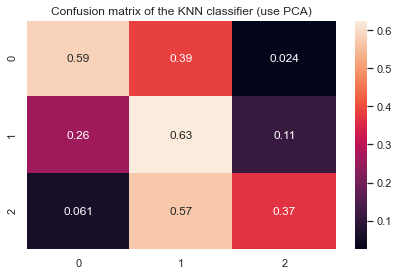

In [43]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

import seaborn as sns; sns.set()


# Calculate the accuracy of prediction
metrics = list()
cm = dict()

# Precision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)

metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                          'fscore':fscore, 'accuracy':accuracy}, 
                         name='Model'))

metrics = pd.concat(metrics, axis=1)

print(metrics)

y_pred = knn.predict(X_test)
print(y_pred)

# Last, the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.2g');
plt.title('Confusion matrix of the KNN classifier (use PCA)')    
plt.tight_layout()

In [44]:
# another way to calculate the prediction accuracy by using a KNN built-in method
mean_accuracy = knn.score(X_test,y_test)
print(mean_accuracy)

0.5677312775330396


We will try now to get the quality prediction for a new wine that comes with the full sets of parameters:
'color', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density', 'pH','sulphates','alcohol'

Examples:
    red wine:          [1,7.4,0.7,0,1.9,0.76,11,34,0.9978,3.51,0.56,9.4]
    white wine:        [0,6.6,0.17,0.38,1.5,0.032,28,112,0.9914,3.25,0.55,11.4]


In [45]:
X0 = [[1,7.4,0.7,0,1.9,0.76,11,34,0.9978,3.51,0.56,9.4],[0,6.6,0.17,0.38,1.5,0.032,28,112,0.9914,3.25,0.55,11.4]]
dfX=pd.DataFrame(X0)

print("===Wines (new data)=====================================================")

dfX.columns = ['color', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density', 'pH','sulphates','alcohol']
dfX.index = ['red_wine_0','white_wine_0']
print(dfX)

===Wines (new data)=====================================================
              color  fixed acidity  volatile acidity  citric acid  \
red_wine_0        1            7.4              0.70         0.00   
white_wine_0      0            6.6              0.17         0.38   

              residual sugar  chlorides  free sulfur dioxide  \
red_wine_0               1.9      0.760                   11   
white_wine_0             1.5      0.032                   28   

              total sulfur dioxide  density    pH  sulphates  alcohol  
red_wine_0                      34   0.9978  3.51       0.56      9.4  
white_wine_0                   112   0.9914  3.25       0.55     11.4  


In [46]:
inxs = dfX.index
dfX = dfX.drop(columns=['color'])

#transpose this set into eigenspace
XPcaDf0 = pca.transform(dfX)
XPcaDf0 = pd.DataFrame(data = XPcaDf0,columns = ['Dim1','Dim2','Dim3','Dim4','Dim5','Dim6','Dim7','Dim8','Dim9','Dim10','Dim11'])

if (DIM_NO == 8):
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)
elif (DIM_NO == 7):
    XPcaDf0 = XPcaDf0.drop('Dim8', 1)
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)
elif (DIM_NO == 6):
    XPcaDf0 = XPcaDf0.drop('Dim7', 1)
    XPcaDf0 = XPcaDf0.drop('Dim8', 1)
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)
elif (DIM_NO == 5):
    XPcaDf0 = XPcaDf0.drop('Dim6', 1)
    XPcaDf0 = XPcaDf0.drop('Dim7', 1)
    XPcaDf0 = XPcaDf0.drop('Dim8', 1)
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)
elif (DIM_NO == 4):
    XPcaDf0 = XPcaDf0.drop('Dim5', 1)
    XPcaDf0 = XPcaDf0.drop('Dim6', 1)
    XPcaDf0 = XPcaDf0.drop('Dim7', 1)
    XPcaDf0 = XPcaDf0.drop('Dim8', 1)
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)
elif (DIM_NO == 3):
    XPcaDf0 = XPcaDf0.drop('Dim4', 1)
    XPcaDf0 = XPcaDf0.drop('Dim5', 1)
    XPcaDf0 = XPcaDf0.drop('Dim6', 1)
    XPcaDf0 = XPcaDf0.drop('Dim7', 1)
    XPcaDf0 = XPcaDf0.drop('Dim8', 1)
    XPcaDf0 = XPcaDf0.drop('Dim9', 1)
    XPcaDf0 = XPcaDf0.drop('Dim10', 1)
    XPcaDf0 = XPcaDf0.drop('Dim11', 1)

print(XPcaDf0)

        Dim1       Dim2       Dim3       Dim4       Dim5       Dim6       Dim7
0 -17.502667   3.129794  -1.287362  11.816158  -2.634340  14.709997 -12.048578
1 -62.927214  10.105678 -10.145147  33.795661 -17.949927  33.903348 -25.356967


In [47]:
# apply normalization to the eigenspace
XPcaDf0 = scaler.transform(XPcaDf0)
print(XPcaDf0)




y0_pred = knn.predict(XPcaDf0)

print("\n===Predicted Quality====================================================")
print(f"{inxs[0]}:\t{y0_pred[0]}")
print(f"{inxs[1]}:\t{y0_pred[1]}")

[[ -9.95152176   1.98791933  -1.03322768  12.20426     -3.09309494
   18.88205783 -16.72545009]
 [-35.77863603   6.41872012  -8.14242652  34.90567889 -21.0758004
   43.51904169 -35.19972965]]

===Predicted Quality====================================================
red_wine_0:	5
white_wine_0:	6


In [48]:
# end timer

end = time.time() 
print(end - start)


3.361283302307129
